<a href="https://colab.research.google.com/github/Samuelameningayeh/thesis/blob/main/synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [188]:
# import cmdstanpy
# cmdstanpy.install_cmdstan()


In [189]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from cmdstanpy import CmdStanModel, cmdstan_path
from cmdstanpy import from_csv
import arviz as az
from pathlib import Path
from datetime import datetime

from loadData import load_data
from imputeMissing import impute_value
from add_noise import Add_noise
from posterior import plot_posterior_kde_grid

from scipy.integrate import odeint

import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

# Define the SEIR model

In [190]:
# ---- SEIR ODE system --------------------------------------------------------
def seir(state, t, beta, sigma, gamma, N):
    n=len(N)
    S = state[:n]
    E = state[n:2*n]
    I = state[2*n:3*n]
    R = state[3*n:4*n]
    C = state[4*n:5*n]
    # C = y[5*n*n:].reshape(n, n)

    dS = np.zeros(n)
    dE = np.zeros(n)
    dI = np.zeros(n)
    dR = np.zeros(n)
    # dD = np.zeros(n)
    dC = np.zeros(n)
    
    for i in range(n):
        dS[i] = -beta[i] * S[i] * I[i] / N[i]
        dE[i] =  beta[i] * S[i] * I[i] / N[i] - sigma * E[i]
        dI[i] =  sigma * E[i] - gamma * I[i]
        dR[i] =  gamma * I[i]
        dC[i] = sigma * E[i]
    
    return np.concatenate([dS.flatten(), dE.flatten(), dI.flatten(), dR.flatten(), dC.flatten()])


# Define Parameters

In [191]:
120*7

840

In [299]:
n_regions = 3 
T = 120 
# Time vector
t = np.linspace(0, T-1, T)

N = [11.5e6, 4.5e6, 6.8e6]  # Guinea, Liberia, Sierra Leone
# N=[4e6, 2.5e6, 2e6]

## Get the Parameters
beta = np.array([0.3, 0.4, 0.35])*7  # Transmission rate (R0 = beta/gamma)
sigma = (1/8.5)*7         # 1/latent period (Ebola: ~10 days) Average value
gamma = (1/6)*7         # 1/infectious period (Ebola: ~7 days)
phi = 10            # Negative binomial dispersion parameter
reporting_rate = 1  # Proportion of cases reported

# Initial conditions
E0 = np.array([1, 1, 1])
I0 = np.array([10, 10, 10])
R0 = np.array([0,0,0])
C0 = np.array([10, 10, 10])
S0 = np.array([N[0]-I0[0]-E0[0], N[1]-I0[1]-E0[1], N[2]-I0[2]-E0[2]])

# initial_state = [guinea, lib, sir]
y0 = np.concatenate([S0.flatten(), E0.flatten(), I0.flatten(), R0.flatten(), C0.flatten()])


# Solve the ODEs

In [193]:
# Simulate SEIR for each region
sol = odeint(seir, y0, t, args=(beta, sigma, gamma, N))

In [194]:
n = 3
# Extract and aggregate results
# S = sol[:, :n]
# E = sol[:, n:2*n]
# I = sol[:, 2*n:3*n]
# R = sol[:, 3*n:4*n]
# D = sol[:, 4*n:]

## Total per patch (sum over resident patches i)
S_total = sol[:, :n]
E_total = sol[:, n:2*n]
I_total = sol[:, 2*n:3*n]
R_total = sol[:, 3*n:4*n]
C_total = sol[:, 4*n:]

## get the new infected individuals at each time
Infections = np.zeros([T, n])
for j in range(3):
    # new_infections = []
    for i in (range(len(C_total))):

        if (i+1 == len(C_total)):
            new_infections = [0.0,0.0,0.0]
            Infections[i, j] = new_infections[j]
        else:
            new_infections = C_total[i+1] - C_total[i]
            Infections[i+1, j] = new_infections[j]

## Show New infections

In [195]:
Infections

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.88667207e+00, 7.95398374e+00, 6.90094807e+00],
       [1.12958546e+01, 1.78046490e+01, 1.43323186e+01],
       [1.60338020e+01, 3.06825368e+01, 2.24813556e+01],
       [2.23571956e+01, 5.23143271e+01, 3.47842353e+01],
       [3.11356536e+01, 8.91510370e+01, 5.37777385e+01],
       [4.33570250e+01, 1.51918063e+02, 8.31379114e+01],
       [6.03749290e+01, 2.58863369e+02, 1.28525134e+02],
       [8.40719844e+01, 4.41057655e+02, 1.98685821e+02],
       [1.17069225e+02, 7.51377393e+02, 3.07135561e+02],
       [1.63015806e+02, 1.27972090e+03, 4.74754665e+02],
       [2.26991958e+02, 2.17867557e+03, 7.33788930e+02],
       [3.16069478e+02, 3.70649748e+03, 1.13400641e+03],
       [4.40091102e+02, 6.29816992e+03, 1.75214867e+03],
       [6.12753527e+02, 1.06802484e+04, 2.70638155e+03],
       [8.53111249e+02, 1.80489542e+04, 4.17825511e+03],
       [1.18766227e+03, 3.03249729e+04, 6.44575022e+03],
       [1.65323630e+03, 5.04578

## Add Noise

In [196]:
observed_cases = Add_noise(Infections, reporting_rate= reporting_rate, phi=phi, seed=10)
b = pd.DataFrame(observed_cases, columns = ['Guinea', 'Liberia', 'Sierra Leone'])
b.head()

,Guinea,Liberia,Sierra Leone
0,0,0,0
1,2,14,8
2,13,21,18
3,12,30,24
4,25,50,63


## Create a dataframe

In [197]:
# Create dataset
data = {
    'time': pd.date_range(start='2013-12-28', periods=T, freq='D'),
    'Day': t.astype(int),
    'S_Guinea': S_total[:, 0],
    'E_Guinea': E_total[:, 0],
    'I_Guinea': I_total[:, 0],
    'R_Guinea': R_total[:, 0],
    'C_Guinea': C_total[:, 0],
    'Guinea_New_case': Infections[:, 0],
    'Guinea_Noise' : b['Guinea'],

    'S_Liberia': S_total[:, 1],
    'E_Liberia': E_total[:, 1],
    'I_Liberia': I_total[:, 1],
    'R_Liberia': R_total[:, 1],
    'C_Liberia': C_total[:, 1],
    'Liberia_New_case': Infections[:, 1],
    'Liberia_Noise' : b['Liberia'],

    'S_SierraLeone': S_total[:, 2],
    'E_SierraLeone': E_total[:, 2],
    'I_SierraLeone': I_total[:, 2],
    'R_SierraLeone': R_total[:, 2],
    'C_SierraLeone': C_total[:, 2],
    'SierraLeone_New_case': Infections[:, 2],
    'SierraLeone_Noise' : b['Sierra Leone'],
}

raw = pd.DataFrame(data)
# df.to_csv('synthetic_ebola_dataset_with_death.csv', index=False)
raw.head()

,time,Day,S_Guinea,E_Guinea,I_Guinea,R_Guinea,C_Guinea,Guinea_New_case,Guinea_Noise,S_Liberia,...,C_Liberia,Liberia_New_case,Liberia_Noise,S_SierraLeone,E_SierraLeone,I_SierraLeone,R_SierraLeone,C_SierraLeone,SierraLeone_New_case,SierraLeone_Noise
0,2013-12-28,0,1.149999e+07,1.000000,10.000000,0.000000,10.000000,0.000000,0,4.499989e+06,...,10.000000,0.000000,0,6.799989e+06,1.000000,10.000000,0.000000,10.000000,0.000000,0
1,2013-12-29,1,1.149997e+07,11.076977,7.017964,8.868708,15.886672,5.886672,2,4.499966e+06,...,17.953984,7.953984,14,6.799970e+06,13.384217,7.717508,9.183440,16.900948,6.900948,8
2,2013-12-30,2,1.149996e+07,16.375391,9.094752,18.087775,27.182527,11.295855,13,4.499936e+06,...,35.758633,17.804649,21,6.799947e+06,21.738298,11.246713,19.986553,31.233267,14.332319,18
3,2013-12-31,3,1.149993e+07,22.896321,12.598087,30.618241,43.216329,16.033802,12,4.499885e+06,...,66.441170,30.682537,30,6.799913e+06,33.699454,17.326704,36.387918,53.714622,22.481356,24
4,2014-01-01,4,1.149990e+07,31.892656,17.536531,48.036993,65.573524,22.357196,25,4.499799e+06,...,118.755497,52.314327,50,6.799859e+06,52.106549,26.781309,61.717548,88.498858,34.784235,63


# Plot the results

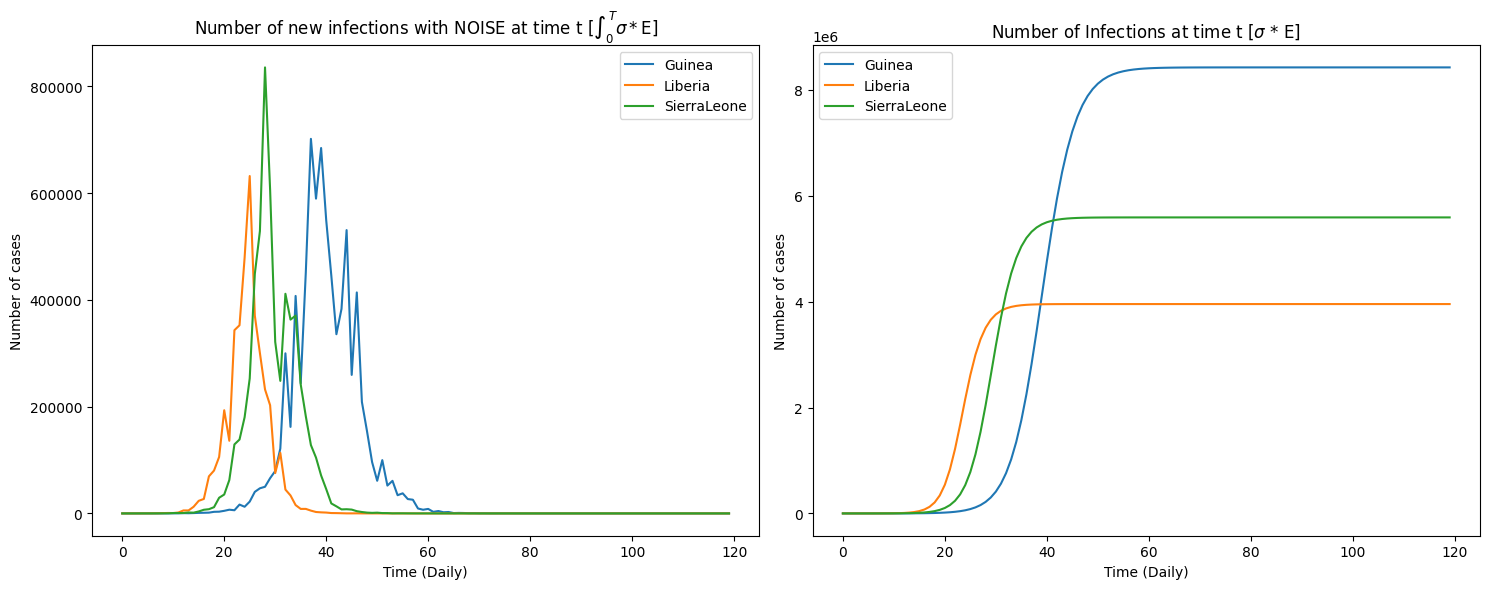

In [198]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
countries = ['Guinea', 'Liberia', 'SierraLeone']
for i in range(3):
    ax[0].plot(raw[f'{countries[i]}_Noise'])
    ax[0].legend(countries)
    ax[0].set_title('Number of new infections with NOISE at time t $[\int_0^T \sigma*$E]')
    ax[0].set_xlabel('Time (Daily)')
    ax[0].set_ylabel('Number of cases')

    ax[1].plot(raw[f'C_{countries[i]}'])
    ax[1].legend(countries)
    ax[1].set_title('Number of Infections at time t [$ \sigma$ * E]')
    ax[1].set_xlabel('Time (Daily)')
    ax[1].set_ylabel('Number of cases')

plt.tight_layout()
plt.show()

# Fit the Model to independent countries

In [199]:
# Aggregate cases by country and week
countries = ['Guinea', 'Liberia', 'Sierra Leone']
# weekly_cases = df.groupby(['country', pd.Grouper(key='time', freq='W')]).sum().unstack(fill_value=0).T
weekly_cases1 = raw['Guinea_Noise']
weekly_cases2 = raw['Liberia_Noise']
weekly_cases3 = raw['SierraLeone_Noise']

cases1 = weekly_cases1.values  # Shape: (T, 3)
cases2 = weekly_cases2.values  # Shape: (T, 3)
cases3 = weekly_cases3.values  # Shape: (T, 3)

N = np.array([11.5e6, 4.5e6, 6.8e6]) 
# Set the population size
beta = np.array([0.3, 0.4, 0.35])*7  # Transmission rate (R0 = beta/gamma)
sigma = (1/8.5)*7         # 1/latent period (Ebola: ~10 days) Average value
gamma = (1/6)*7 

# Define initial conditions
i0 = [10, 10, 10]
e0 = [1, 1, 1]
s0 = N - i0 - e0
r0 = [0, 0, 0]
c0 = [10, 10, 10]
y1 = [s0[0], e0[0], i0[0], r0[0], c0[0]]
y2 = [s0[1], e0[1], i0[1], r0[1], c0[1]]
y3 = [s0[2], e0[2], i0[2], r0[2], c0[2]]


In [200]:

# Make the data struture
seir_data1 = {
    "n_days": len(cases1),
    "y0": y1,
    "t0": 0,
    "t": np.arange(1, len(cases1)+1),
    "N": int(N[0]),
    "cases": cases1,
    "beta_value": beta[0],
    "sigma_value": sigma,
    "gamma_value": gamma,
    "reporting_rate": reporting_rate
}

seir_data2 = {
    "n_days": len(cases2),
    "y0": y2,
    "t0": 0,
    "t": np.arange(1, len(cases2)+1),
    "N": int(N[1]),
    "cases": cases2,
    "beta_value": beta[1],
    "sigma_value": sigma,
    "gamma_value": gamma,
    "reporting_rate": reporting_rate
}
seir_data3 = {
    "n_days": len(cases3),
    "y0": y3,
    "t0": 0,
    "t": np.arange(1, len(cases3)+1),
    "N": int(N[2]),
    "cases": cases3,
    "beta_value": beta[2],
    "sigma_value": sigma,
    "gamma_value": gamma,
    "reporting_rate": reporting_rate
}

In [201]:
country = 'Guinea_week'

print(f'Compiling stan file for {country}...\n')
seir_incidence_model = CmdStanModel(stan_file = 'stan files/guinea.stan')
print(f'Compiling done...!')

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f'\nRunning model fit for Guinea at time {timestamp}...\n')
fit1 = seir_incidence_model.sample(data = seir_data1, 
                                    iter_sampling = 1000,
                                    parallel_chains = True,
                                    chains = 4,
                                    seed = 0)

## save to output folder
output_dir = f'model_output/{country}_{timestamp}'
Path(output_dir).mkdir(parents=True, exist_ok=True)

fit1.save_csvfiles(dir=output_dir)
print(f'\nFit for {country} saved to: {output_dir}')

if __name__ == "__main__":
    print(f"Fits for {country} completed. Check 'model_output/' directory")

Compiling stan file for Guinea_week...

Compiling done...!

Running model fit for Guinea at time 20250610_152232...



chain 1 |          | 00:00 Status


chain 1 |██████████| 04:17 Iteration: 1900 / 2000 [ 95%]  (Sampling)































































chain 1 |██████████| 16:00 Sampling completed                       
chain 2 |██████████| 16:00 Sampling completed                       
chain 3 |██████████| 16:00 Sampling completed                       
chain 4 |██████████| 16:00 Sampling completed                       



Fit for Guinea_week saved to: model_output/Guinea_week_20250610_152232
Fits for Guinea_week completed. Check 'model_output/' directory


In [238]:
country = 'Liberia_week'
print(f'Compiling stan file for {country}...\n')
seir_incidence_model1 = CmdStanModel(stan_file = 'stan files/lib.stan')
print(f'Compiling done...!')

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f'Running model fit for Guinea at time {timestamp}...\n')

fit2 = seir_incidence_model1.sample(data = seir_data2, 
                                    iter_sampling = 1000,
                                    parallel_chains = True,
                                    chains = 4,
                                    seed = 0)

## save to output folder
output_dir = f'model_output/{country}_{timestamp}'
Path(output_dir).mkdir(parents=True, exist_ok=True)

fit2.save_csvfiles(dir=output_dir)
print(f'\nFit for {country} saved to: {output_dir}')

if __name__ == "__main__":
    print(f"Fits for {country} completed. Check 'model_output/' directory")

Compiling stan file for Liberia_week...

Compiling done...!
Running model fit for Guinea at time 20250610_170653...



chain 1 |          | 00:00 Status


chain 1 |██████████| 02:26 Iteration: 1900 / 2000 [ 95%]  (Sampling)
































































chain 1 |██████████| 09:38 Sampling completed                       
chain 2 |██████████| 09:38 Sampling completed                       
chain 3 |██████████| 09:38 Sampling completed                       
chain 4 |██████████| 09:38 Sampling completed                       



Fit for Liberia_week saved to: model_output/Liberia_week_20250610_170653
Fits for Liberia_week completed. Check 'model_output/' directory


In [245]:
country = 'Sierra_Leone_week'
print(f'Compiling stan file for {country}...\n')
seir_incidence_model2 = CmdStanModel(stan_file = 'stan files/sierra.stan')
print(f'Compiling done...!')

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f'Running model fit for Guinea at time {timestamp}...\n')

fit3 = seir_incidence_model2.sample(data = seir_data3,
                                    iter_sampling = 1000,
                                    parallel_chains = True,
                                    chains = 4,
                                    seed = 0)

## save to output folder
output_dir = f'model_output/{country}_{timestamp}'
Path(output_dir).mkdir(parents=True, exist_ok=True)

fit3.save_csvfiles(dir=output_dir)
print(f'\nFit for {country} saved to: {output_dir}')

if __name__ == "__main__":
    print(f"Fits for {country} completed. Check 'model_output/' directory")

Compiling stan file for Sierra_Leone_week...

Compiling done...!
Running model fit for Guinea at time 20250610_172630...



chain 1 |          | 00:00 Status


chain 1 |██████████| 03:04 Iteration: 1900 / 2000 [ 95%]  (Sampling)































































chain 1 |██████████| 15:10 Sampling completed                       
chain 2 |██████████| 15:10 Sampling completed                       
chain 3 |██████████| 15:10 Sampling completed                       
chain 4 |██████████| 15:10 Sampling completed                       



Fit for Sierra_Leone_week saved to: model_output/Sierra_Leone_week_20250610_172630
Fits for Sierra_Leone_week completed. Check 'model_output/' directory


In [254]:
fit1 = from_csv('model_output/Guinea_week_20250610_152232/guinea-*_*.csv')
print("Guinea fit loaded")

fit2 = from_csv('model_output/Liberia_week_20250610_170653/lib-*_*.csv')
print("Liberia fit loaded")

fit3 = from_csv('model_output/Sierra_Leone_week_20250610_172630/sierra-*_*.csv')
print("Sierra Leone fit loaded")

Guinea fit loaded
Liberia fit loaded
Sierra Leone fit loaded


In [248]:
print(fit3.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [255]:
fit1_summary = fit1.summary()
fit1_summary.filter(items=("sigma", "beta", "recovery_time", "gamma", "incubation_period", "R0", "phi", "phi_inv"), axis=0)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
sigma,0.917990,0.002504,0.115939,0.113581,0.746586,0.909484,1.12213,2141.63,1959.69,1.00064
beta,1.720100,0.005557,0.185283,0.180699,1.451050,1.703570,2.05252,1196.62,1174.31,1.00160
recovery_time,1.083560,0.004317,0.153290,0.155368,0.846089,1.075470,1.33560,1239.37,1299.17,1.00124
gamma,0.941607,0.004000,0.135199,0.133571,0.748728,0.929824,1.18191,1239.37,1299.17,1.00234
incubation_period,1.106420,0.002987,0.137441,0.138653,0.891158,1.099530,1.33943,2141.63,1959.69,1.00044
R0,1.837980,0.002564,0.107239,0.104027,1.682990,1.826200,2.03079,1864.52,1861.12,1.00029
phi,9.724090,0.038742,1.776740,1.714580,7.079120,9.546590,12.83480,2083.68,1775.53,1.00096
phi_inv,0.106337,0.000449,0.019807,0.018884,0.077913,0.104749,0.14126,2083.69,1775.53,1.00081


In [249]:
fit2_summary = fit2.summary()
fit2_summary.filter(items=("sigma", "beta", "recovery_time", "gamma", "incubation_period", "R0", "phi", "phi_inv"), axis=0)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
sigma,1.000860,0.003475,0.158117,0.149809,0.782754,0.981734,1.296960,2173.39,2255.12,1.00110
beta,2.203110,0.006401,0.233956,0.221115,1.885550,2.168200,2.630550,1553.45,1368.51,1.00492
recovery_time,1.095110,0.004627,0.183234,0.184332,0.806623,1.086580,1.400870,1543.17,1416.74,1.00362
gamma,0.939861,0.004408,0.164446,0.155594,0.713843,0.920315,1.239740,1543.16,1416.74,1.00362
incubation_period,1.022990,0.003306,0.154457,0.156695,0.771038,1.018600,1.277540,2173.38,2255.12,1.00110
R0,2.378260,0.005704,0.246326,0.243443,2.011860,2.358570,2.804450,1858.62,1848.30,1.00142
phi,8.402050,0.041314,1.902560,1.854380,5.595330,8.208830,11.838700,2167.28,2221.35,1.00154
phi_inv,0.125291,0.000629,0.029191,0.027402,0.084468,0.121820,0.178721,2167.27,2221.35,1.00118


In [250]:
fit3_summary = fit3.summary()
fit3_summary.filter(items=("sigma", "beta", "recovery_time", "gamma", "incubation_period", "R0", "phi", "phi_inv"), axis=0)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
sigma,0.927631,0.003199,0.128141,0.122730,0.746442,0.913042,1.155920,1757.50,1476.02,1.00385
beta,1.983980,0.005095,0.192422,0.181745,1.707890,1.962170,2.340620,1583.13,1289.42,1.00283
recovery_time,1.107280,0.004115,0.163610,0.164033,0.839882,1.103770,1.378090,1558.76,1332.60,1.00282
gamma,0.923607,0.003718,0.141631,0.134024,0.725642,0.905983,1.190640,1558.74,1332.60,1.00282
incubation_period,1.097860,0.003482,0.146473,0.146424,0.865111,1.095250,1.339690,1757.52,1476.02,1.00448
R0,2.170080,0.004445,0.180528,0.177312,1.899630,2.160410,2.475090,1690.10,1638.72,1.00284
phi,7.493860,0.031146,1.464430,1.466640,5.247900,7.405960,10.065900,2220.03,2241.89,1.00276
phi_inv,0.138724,0.000605,0.028073,0.026967,0.099345,0.135026,0.190552,2220.01,2241.89,1.00310


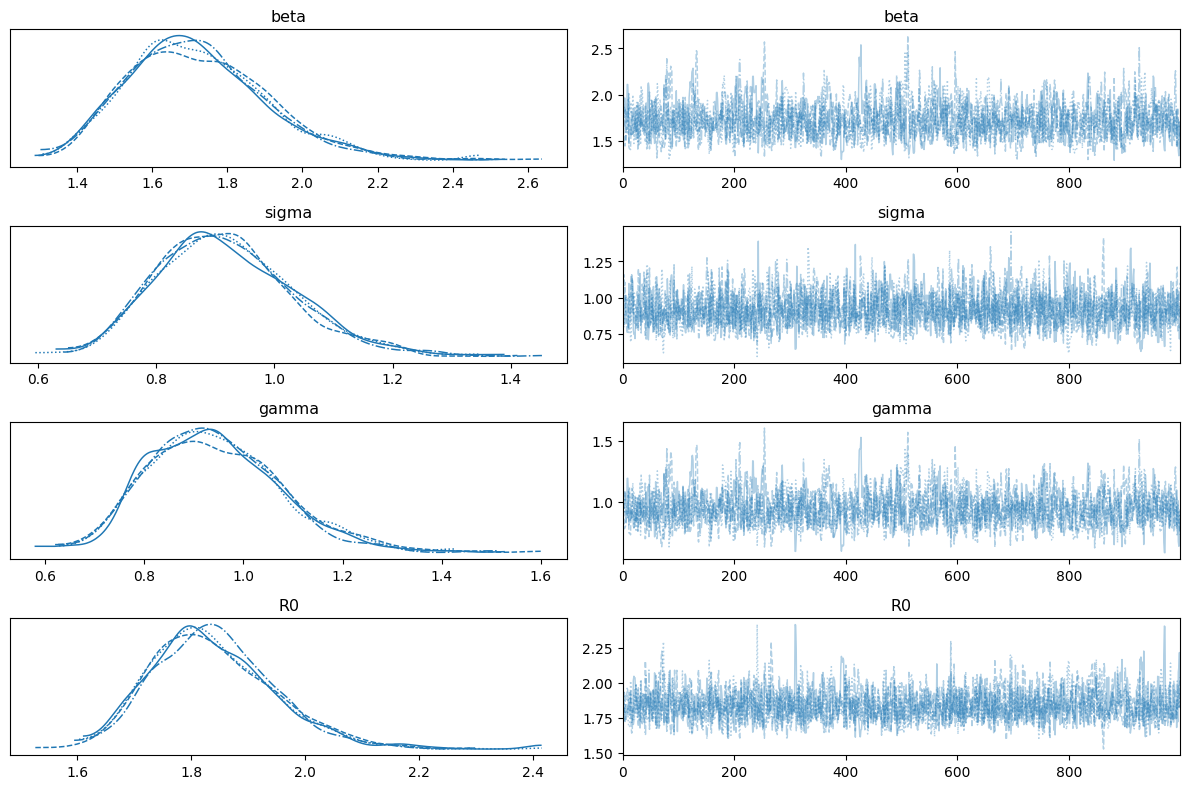

In [256]:
## trace plots
az.plot_trace(fit1, var_names=["beta", "sigma", "gamma", "R0"])
plt.tight_layout()

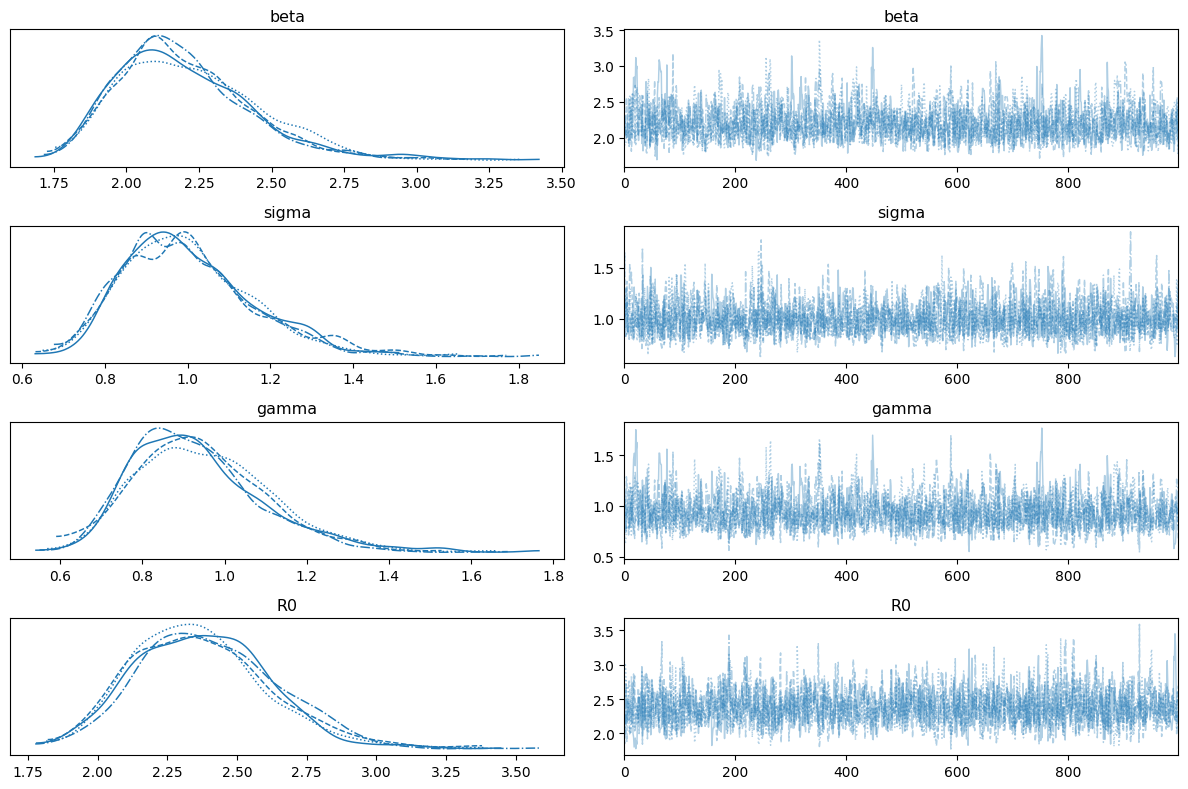

In [252]:
az.plot_trace(fit2, var_names=["beta", "sigma", "gamma", "R0"])
plt.tight_layout()

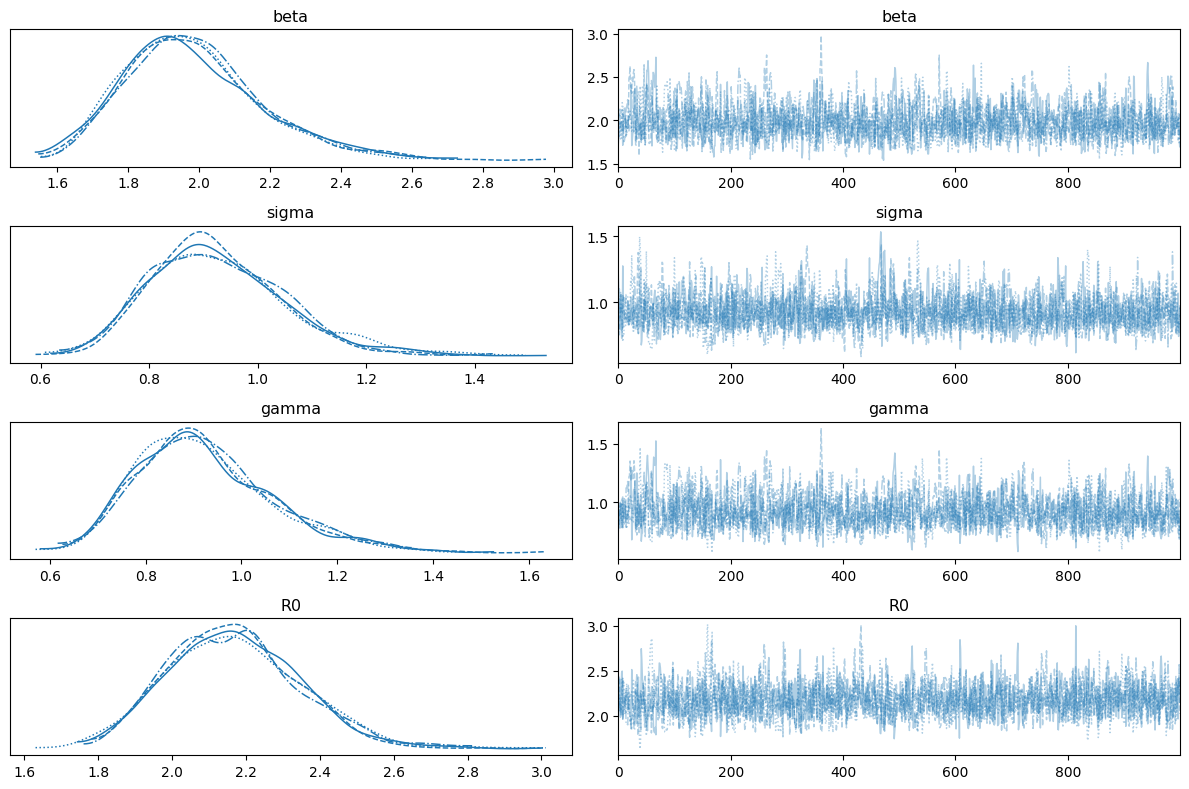

In [257]:
az.plot_trace(fit3, var_names=["beta", "sigma", "gamma", "R0"])
plt.tight_layout()
plt.show()

# Posterior Predictive Checks

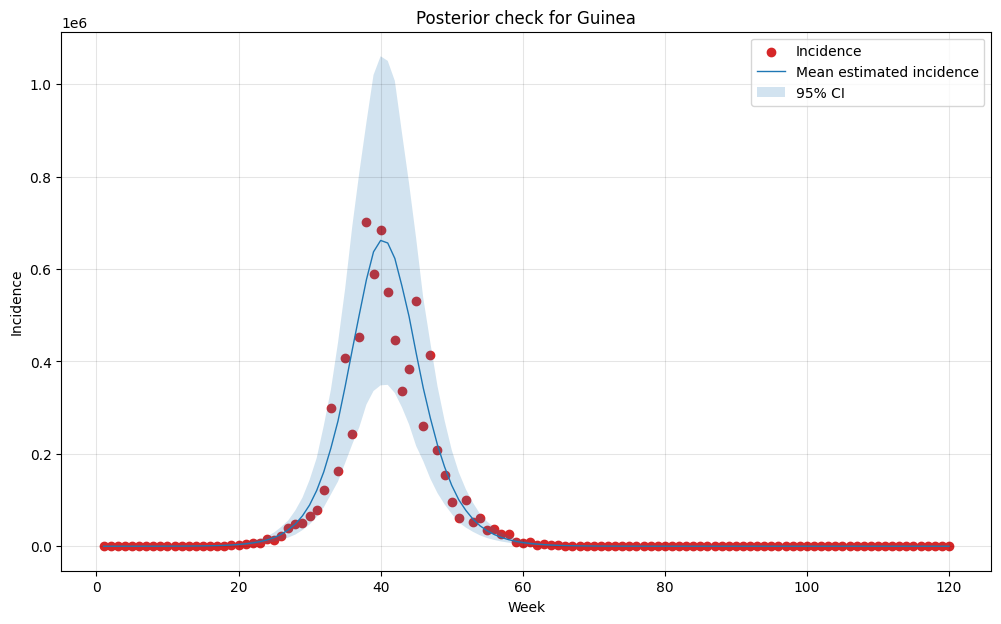

In [258]:
post_pred = pd.DataFrame(fit1_summary.filter(like="pred_incidence", axis=0))
post_pred["t"] = range(1, 121)
post_pred["incidence"] = list(cases1)
post_pred = post_pred.set_index("t")

plt.figure(figsize=(12, 7))
plt.grid(True, which='both', color = 'k', alpha = 0.1)
plt.title(f'Posterior check for Guinea')
plt.ylabel('Incidence')
plt.xlabel('Week')
plt.scatter(x = post_pred.index, y = post_pred.incidence, color = 'tab:red', label = "Incidence")
plt.plot(post_pred.Mean, color = 'tab:blue', linewidth= 1, label = "Mean estimated incidence")
plt.fill_between(x = post_pred.index, y1 = post_pred['5%'], y2 = post_pred['95%'], alpha=0.2, label="95% CI")
# plt.facecolor('white')
plt.legend(loc = "upper right")

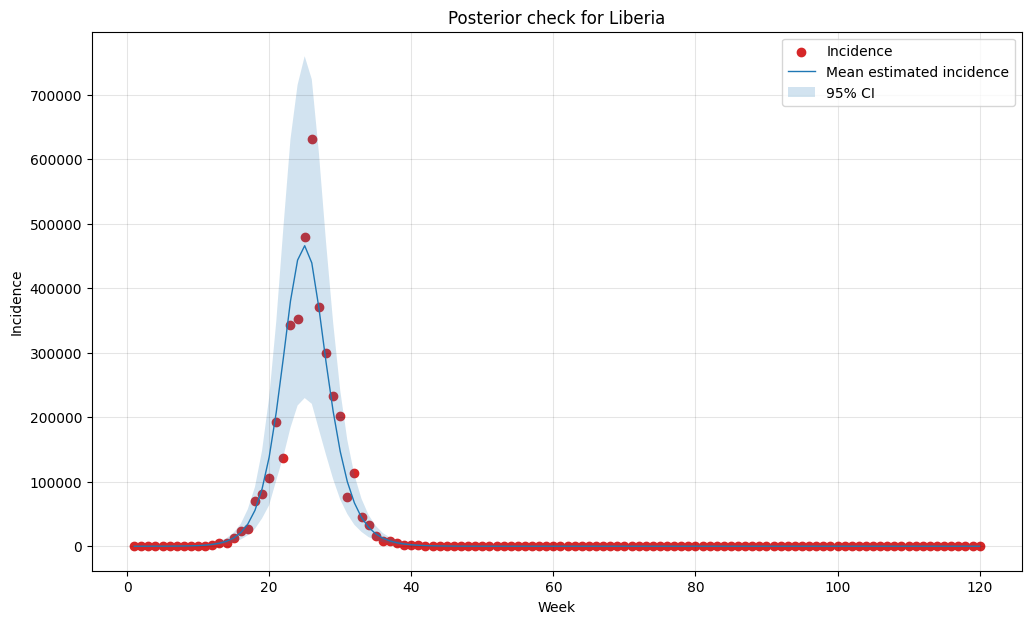

In [261]:
post_pred2 = pd.DataFrame(fit2_summary.filter(like="pred_incidence", axis=0))
post_pred2["t"] = range(1, 121)
post_pred2["incidence"] = list(cases2)
post_pred2 = post_pred2.set_index("t")

plt.figure(figsize=(12, 7))
plt.grid(True, which='both', color = 'k', alpha = 0.1)
plt.title(f'Posterior check for Liberia')
plt.ylabel('Incidence')
plt.xlabel('Week')
plt.scatter(x = post_pred2.index, y = post_pred2.incidence, color = 'tab:red', label = "Incidence")
plt.plot(post_pred2.Mean, color = 'tab:blue', linewidth= 1, label = "Mean estimated incidence")
plt.fill_between(x = post_pred2.index, y1 = post_pred2['5%'], y2 = post_pred2['95%'], alpha=0.2, label="95% CI")
# plt.facecolor('white')
plt.legend(loc = "upper right")

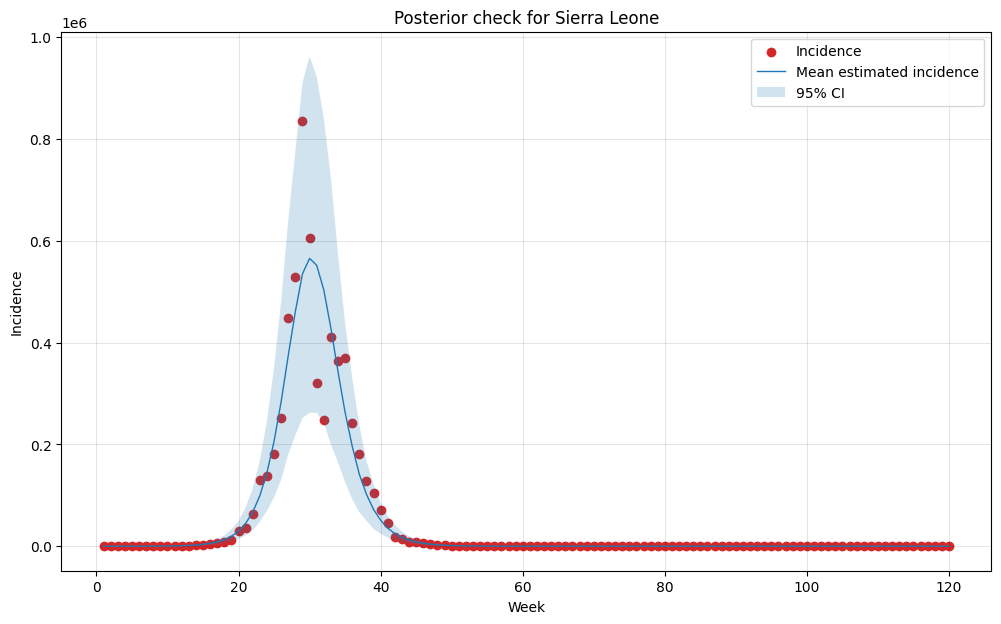

In [262]:
post_pred3 = pd.DataFrame(fit3_summary.filter(like="pred_incidence", axis=0))
post_pred3["t"] = range(1, 121)
post_pred3["incidence"] = list(cases3)
post_pred3 = post_pred3.set_index("t")

plt.figure(figsize=(12, 7))
plt.grid(True, which='both', color = 'k', alpha = 0.1)
plt.title(f'Posterior check for Sierra Leone')
plt.ylabel('Incidence')
plt.xlabel('Week')
plt.scatter(x = post_pred3.index, y = post_pred3.incidence, color = 'tab:red', label = "Incidence")
plt.plot(post_pred3.Mean, color = 'tab:blue', linewidth= 1, label = "Mean estimated incidence")
plt.fill_between(x = post_pred3.index, y1 = post_pred3['5%'], y2 = post_pred3['95%'], alpha=0.2, label="95% CI")
# plt.facecolor('white')
plt.legend(loc = "upper right")

In [295]:
# Assuming `fit` is your CmdStanMCMC object from fitting the model
parameters1 = ["beta", "sigma", "recovery_time", "gamma", "incubation_period", "R0","phi"]

beta = np.array([0.3, 0.4, 0.35])*7  # Transmission rate (R0 = beta/gamma)
sigma = 1/8.5 *7        # 1/latent period (Ebola: ~10 days) Average value
gamma = 1/6*7         # 1/infectious period (Ebola: ~7 days)
phi = 10            # Negative binomial dispersion parameter
reporting_rate = 1
r = beta/gamma
rec = 1.0/gamma
incu = 1.0 / sigma

t1 = {'beta':beta[0],'sigma': sigma, 'gamma': gamma, 'phi': phi ,
    'reporting_rate':reporting_rate, 'R0': r[0], 'recovery_time':rec,
    'incubation_period': incu}

t2 = {'beta':beta[1],'sigma': sigma, 'gamma': gamma, 'phi': phi,
    'reporting_rate':reporting_rate, 'R0': r[1], 'recovery_time':rec,
    'incubation_period': incu}

t3 = {'beta':beta[2],'sigma': sigma, 'gamma': gamma, 'phi': phi ,
    'reporting_rate':reporting_rate, 'R0': r[2], 'recovery_time':rec,
    'incubation_period': incu}

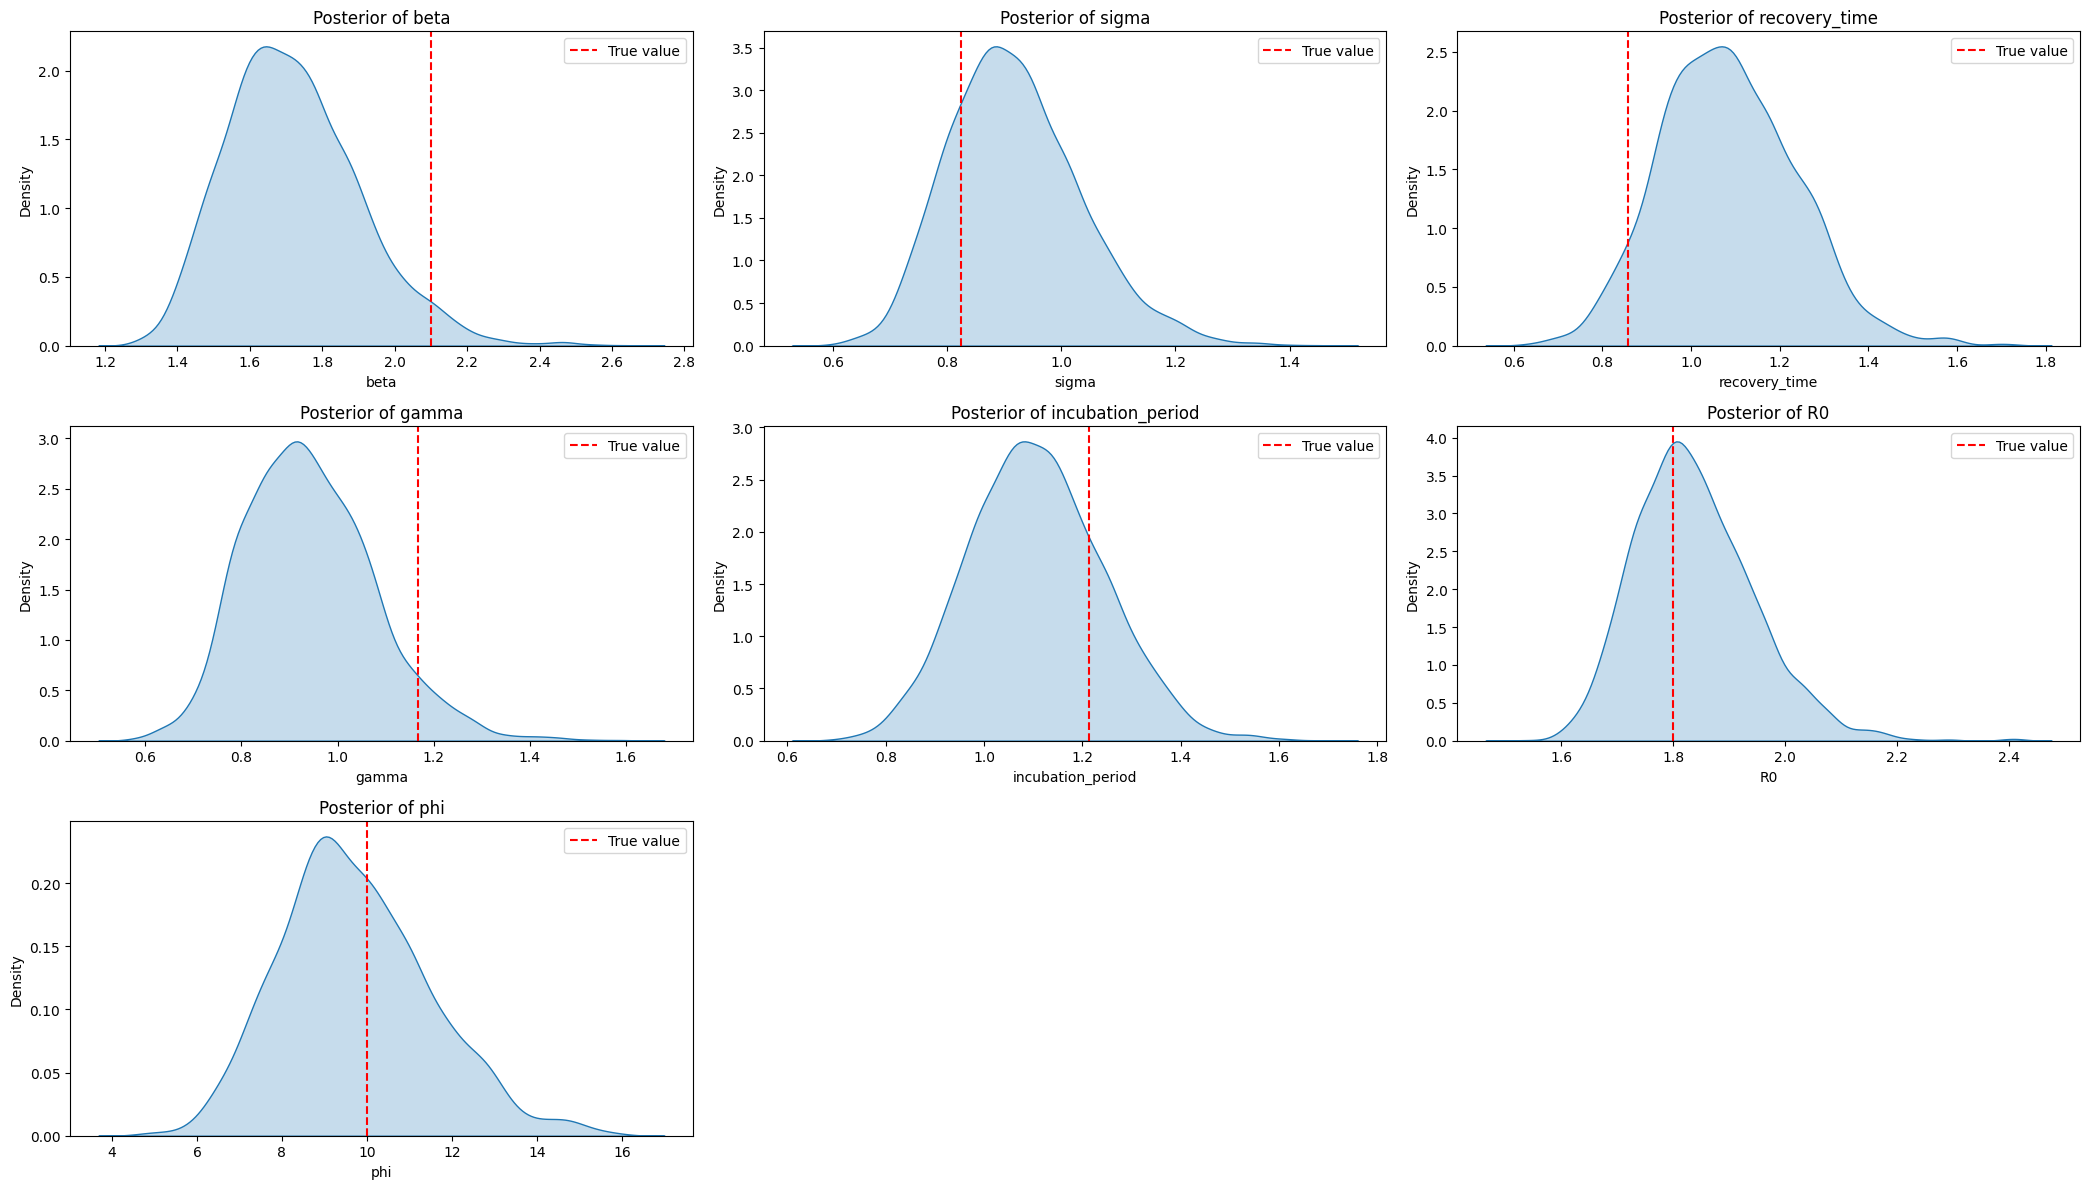

In [296]:
plot_posterior_kde_grid(fit1, parameters1, 3,t1)

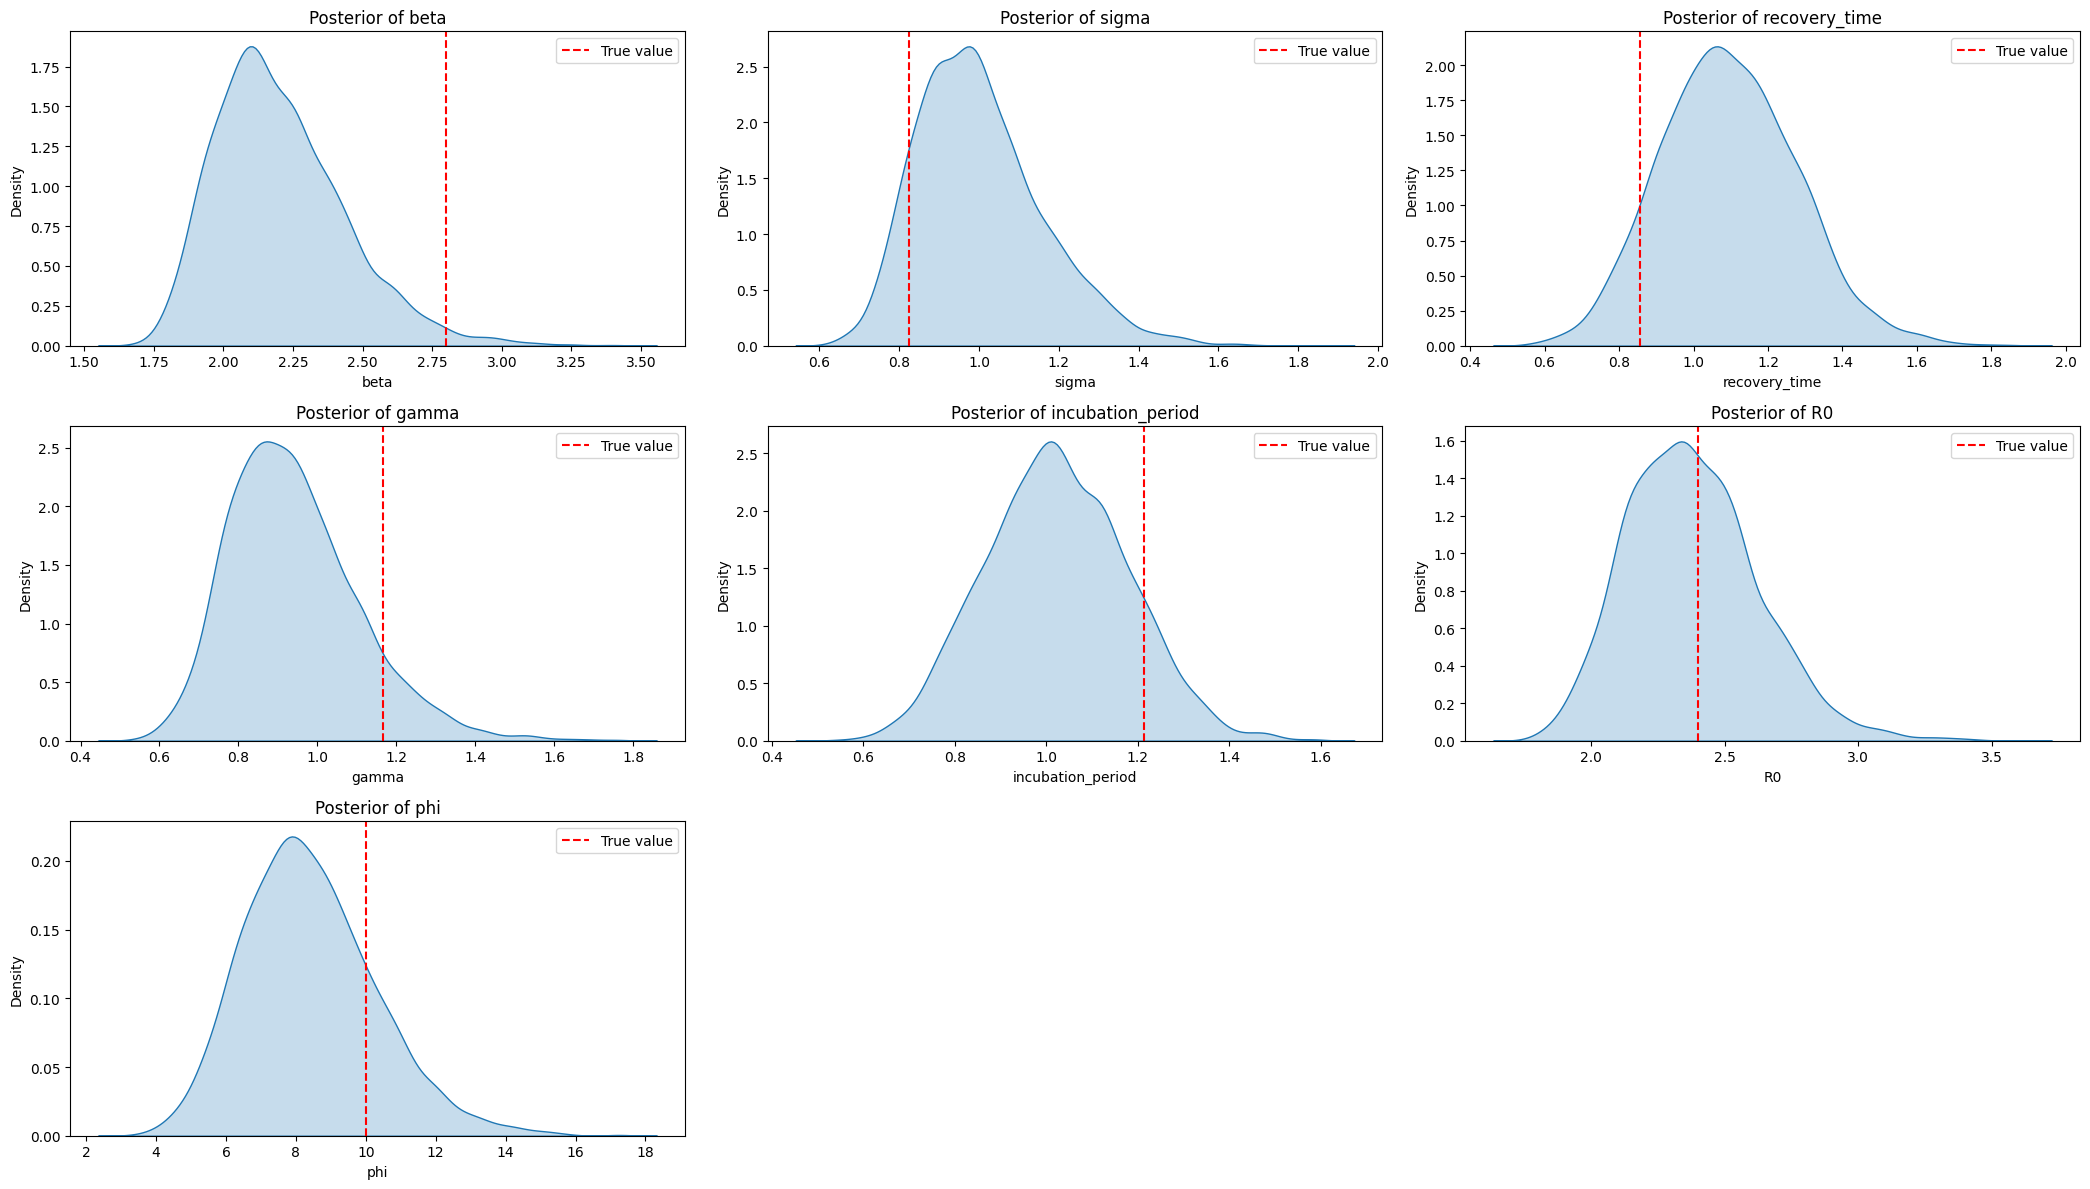

In [297]:
plot_posterior_kde_grid(fit2, parameters1,3,t2)

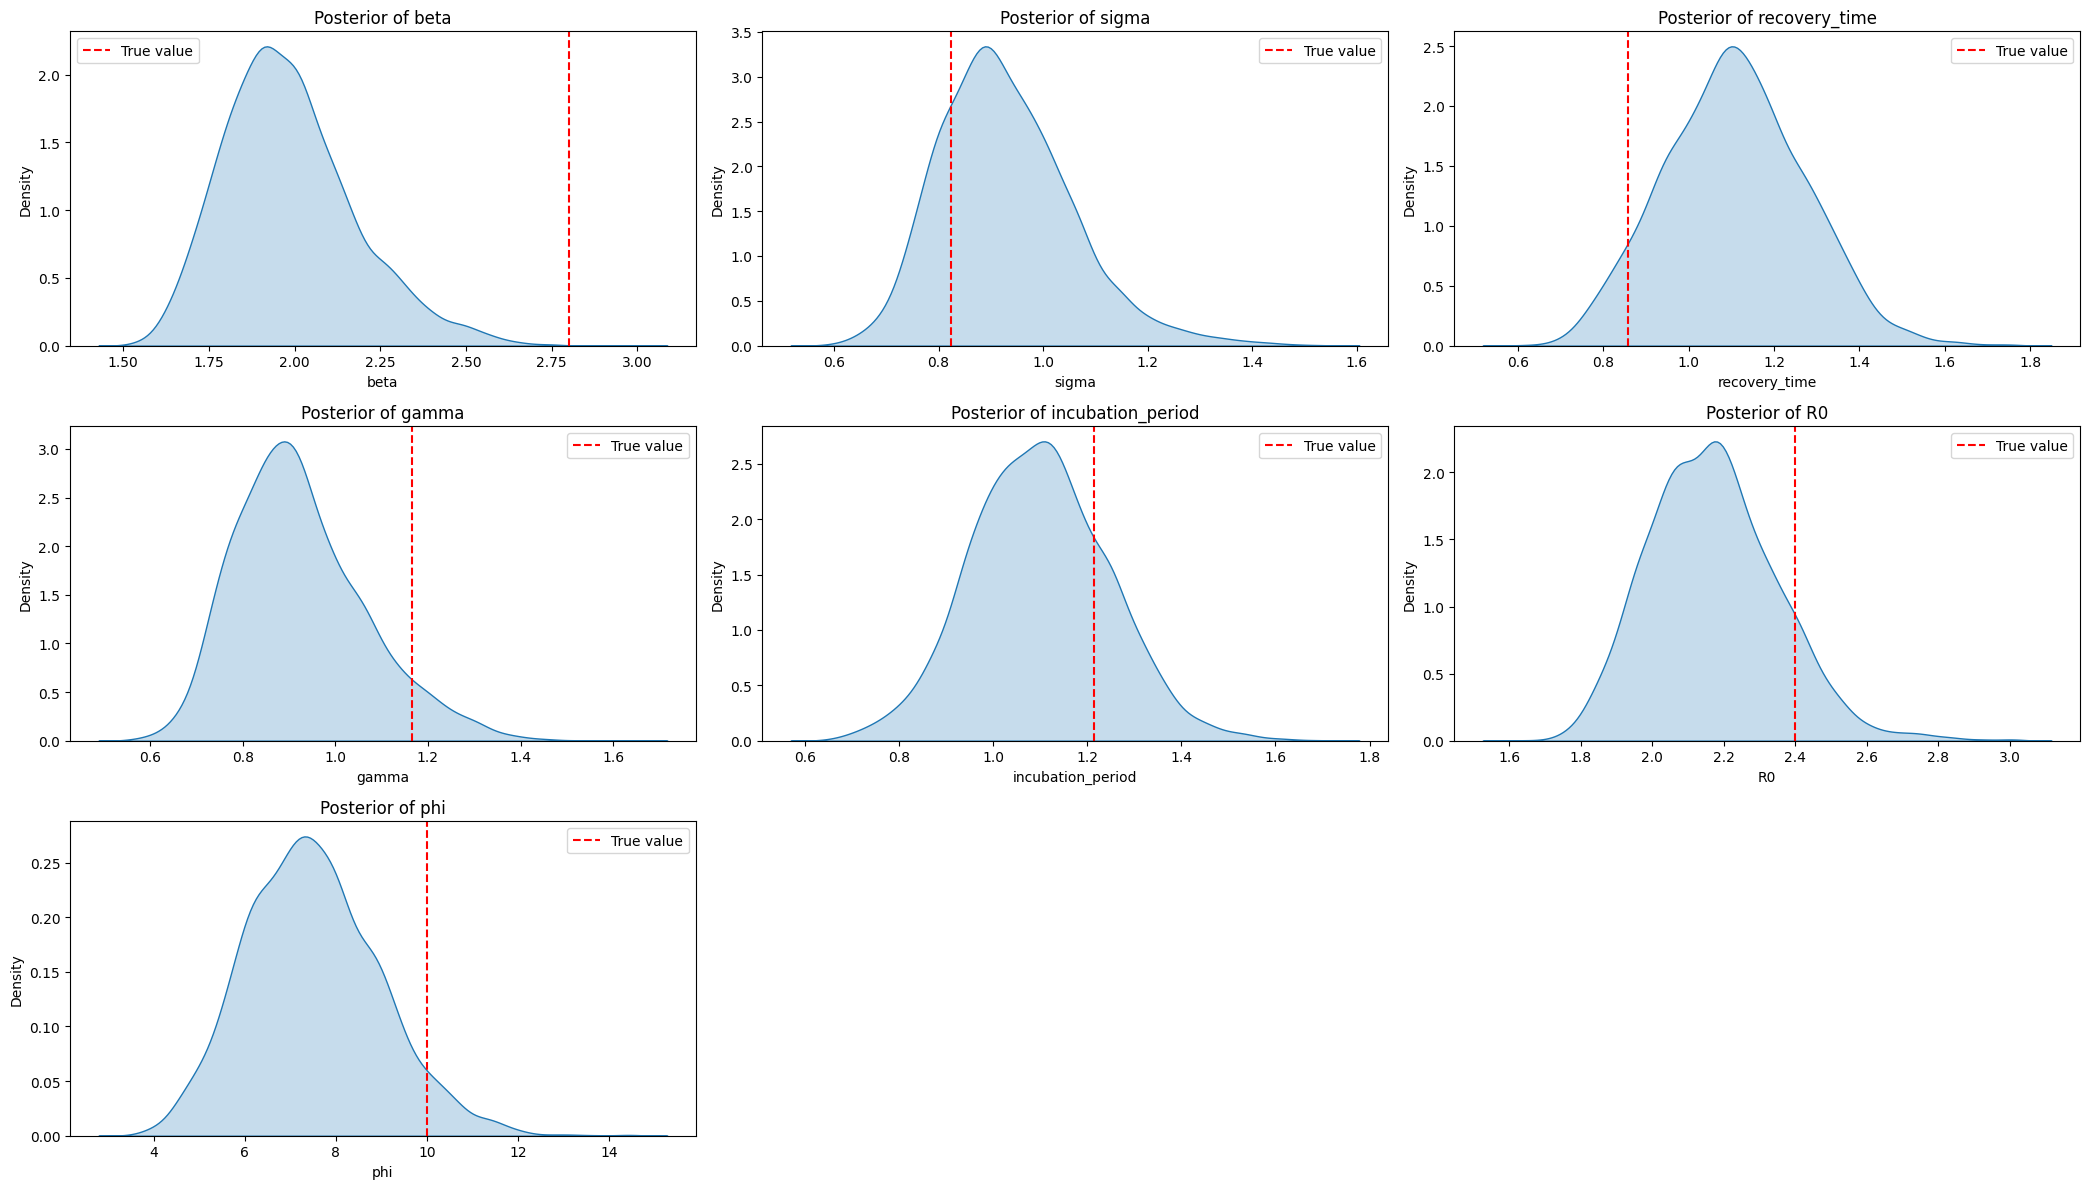

In [298]:
plot_posterior_kde_grid(fit3, parameters1,3,t2)

## Plot SEIR Compartments

In [267]:

def plot_compartment(fit, country_idx):
    # Time points and countries
    weeks = np.arange(fit.stan_variable('incidence').shape[1])  # Number of weeks
    countries = ['Guinea', 'Liberia', 'Sierra Leone']

    # Plot incidence (infectious) and reconstructed other compartments
    # for i in range(countries):
    # Create figure
    plt.figure(figsize=(12, 7))
    incidence = np.mean(fit.stan_variable('incidence'), axis=0)

    # Reconstruct approximate compartments (scaled by reporting rate)
    I = incidence
    R = np.cumsum(I) * np.mean(fit.stan_variable('gamma'))
    E = np.roll(I, 1) / np.mean(fit.stan_variable('sigma'))  # Exposed ~ delayed infectious
    # E[0] = 0
    S = N[country_idx] - E - I - R

    # Convert to fractions
    S_frac = S / N[country_idx]
    E_frac = E / N[country_idx]
    I_frac = I / N[country_idx]
    R_frac = R / N[country_idx]

    # Plot
    plt.plot(weeks, S_frac, 'b', label='Susceptible')
    plt.plot(weeks, E_frac, 'y', label='Exposed')
    plt.plot(weeks, I_frac, 'r', label='Infectious')
    plt.plot(weeks, R_frac, 'g', label='Recovered')

    # Formatting
    plt.title(f'{countries[country_idx]} (R0={np.mean(fit.stan_variable("R0")):.2f})')
    plt.ylabel('Fraction of Population')
    plt.grid(True, alpha=0.3)
    # ax.set_ylim(0, 1)

    plt.legend(loc='upper right')
    plt.xlabel('Weeks since outbreak start')
    # plt.tight_layout()
    plt.show()                                                                                      

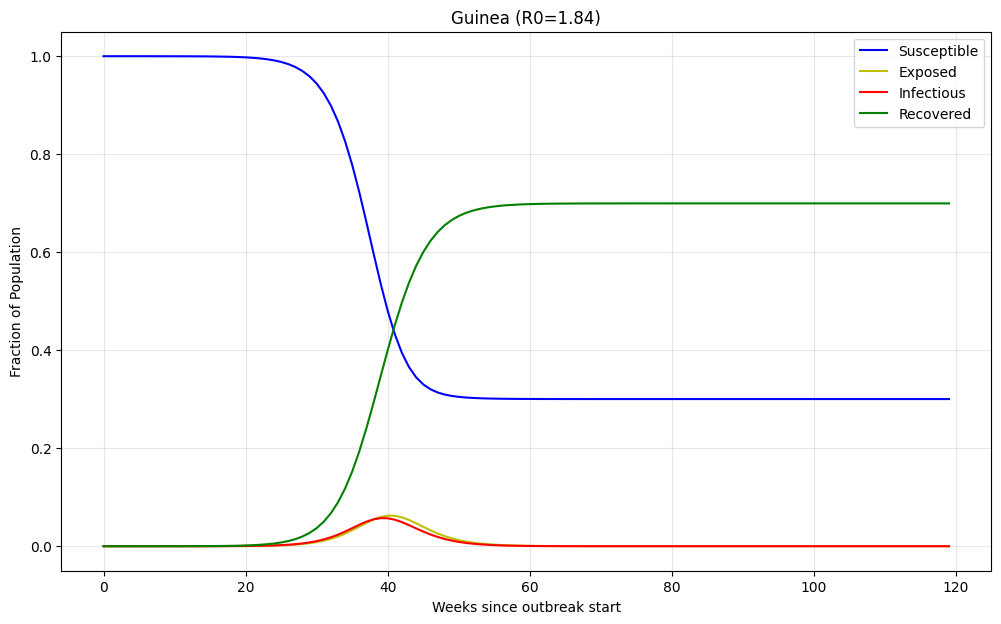

In [ ]:
plot_compartment(fit1, country_idx=0)

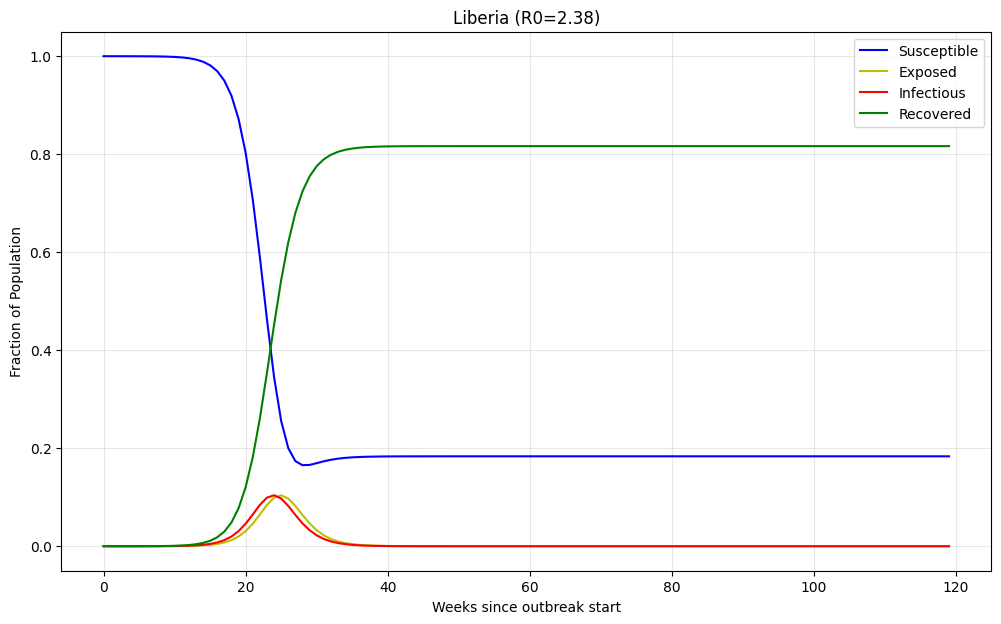

In [269]:

plot_compartment(fit2, country_idx=1)

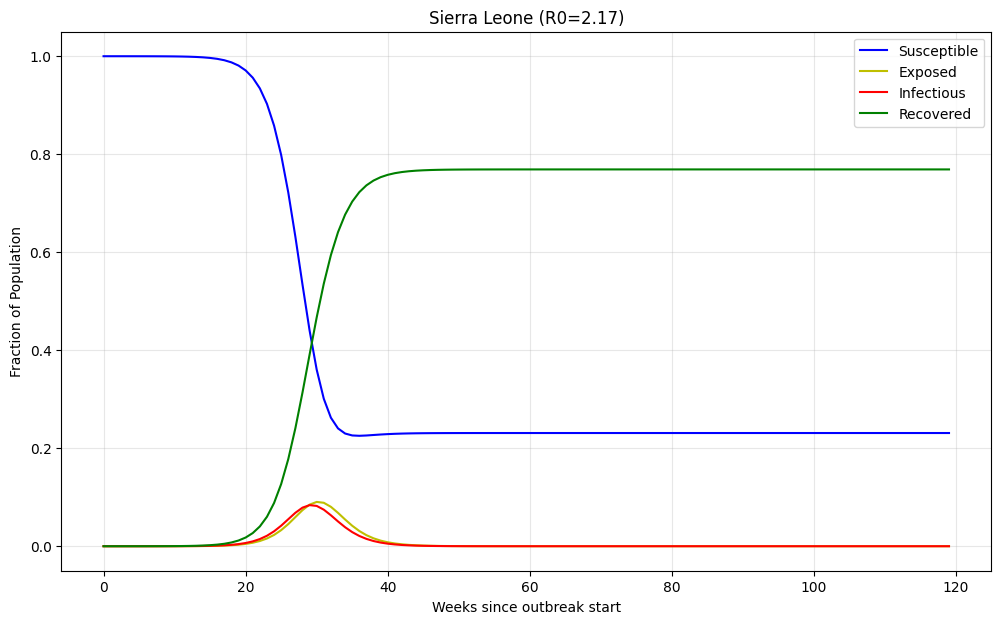

In [271]:

plot_compartment(fit3, country_idx=2)

# FITTING FOR 3 PATCHES

In [300]:
weekly = raw[['Guinea_Noise', 'Liberia_Noise', 'SierraLeone_Noise']]
weekly.head()

,Guinea_Noise,Liberia_Noise,SierraLeone_Noise
0,0,0,0
1,2,14,8
2,13,21,18
3,12,30,24
4,25,50,63


In [301]:
weekly.T.shape

(3, 120)

In [302]:

N = np.array([11.5e6, 4.5e6, 6.8e6]) 
# Set the population size

# Define initial conditions
g0 = [N[0]-10, 1, 10, 0, 10]
l0 = [N[1]-10, 1, 10, 0, 10]
s0 = [N[2]-10, 1, 10, 0, 10]

ts = weekly.values.T
y0 = [g0, l0, s0]

# Make the data struture
seirdata = {
    'N_countries': 3,
    "n_days": len(ts[0]),
    'y0': y0,
    't0': 0,
    "t": np.arange(1, len(ts[0])+1),
    "N": N.astype(int),
    "cases": ts,
    "beta_value": beta,
    "sigma_value": sigma,
    "gamma_value": gamma,
    "reporting_rate": reporting_rate
}

In [303]:
country = 'All_Patch'
print(f'Compiling stan file for {country}...\n')
multi_model = CmdStanModel(stan_file = 'stan files/mult.stan')
print(f'Compiling done...!')

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f'Running model fit for Guinea at time {timestamp}...\n')

fit_multi_model = multi_model.sample(data = seirdata,
                                    iter_sampling = 1000,
                                    parallel_chains = True,
                                    chains = 4,
                                    seed = 10)

## save to output folder
output_dir = f'model_output/{country}_{timestamp}'
Path(output_dir).mkdir(parents=True, exist_ok=True)

fit_multi_model.save_csvfiles(dir=output_dir)
print(f'\nFit for {country} saved to: {output_dir}')

if __name__ == "__main__":
    print(f"Fits for {country} completed. Check 'model_output/' directory")

Compiling stan file for All_Patch...

Compiling done...!
Running model fit for Guinea at time 20250610_185902...



chain 1 |          | 00:00 Status


chain 1 |██████████| 02:17 Iteration: 1900 / 2000 [ 95%]  (Sampling)






























































chain 1 |██████████| 04:10 Sampling completed                       
chain 2 |██████████| 04:10 Sampling completed                       
chain 3 |██████████| 04:10 Sampling completed                       
chain 4 |██████████| 04:10 Sampling completed                       



Fit for All_Patch saved to: model_output/All_Patch_20250610_185902
Fits for All_Patch completed. Check 'model_output/' directory


In [304]:
fit_multi_model = from_csv('model_output/All_Patch_20250610_185902/mult-*_*.csv')
print("All Patch fit loaded")
print(fit_multi_model.diagnose())

All Patch fit loaded
Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [305]:
multy_fit_summary = fit_multi_model.summary()
multy_fit_summary.filter(items=("beta[1]","beta[2]", "beta[3]", "sigma", "recovery_time",
                                 "gamma", "incubation_period", "R0[1]","R0[2]", "R0[3]",
                                   "phi", "phi_inv"), axis=0)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
beta[1],2.005810,0.012390,0.782122,0.678008,1.002580,1.858740,3.49958,4205.67,2987.42,0.999748
beta[2],2.938720,0.018327,1.068020,0.948619,1.570820,2.755990,4.96520,3665.67,3083.70,1.000950
beta[3],2.497980,0.016287,0.929944,0.807179,1.334100,2.345480,4.21610,3542.66,2882.76,1.001470
sigma,0.688566,0.005567,0.313026,0.248628,0.327543,0.616939,1.30331,3638.70,2751.01,1.001890
recovery_time,1.037170,0.008283,0.479921,0.385884,0.480151,0.937545,1.96965,3343.42,2664.47,1.001180
gamma,1.157190,0.009055,0.499083,0.441335,0.507705,1.066620,2.08268,3343.41,2664.47,1.000920
incubation_period,1.728890,0.012075,0.723600,0.662277,0.767282,1.620910,3.05304,3638.69,2751.01,1.001080
R0[1],2.007790,0.018275,1.148080,0.816446,0.817553,1.726570,4.15124,4814.26,3037.19,1.000140
R0[2],2.943350,0.027829,1.624880,1.158880,1.267270,2.528290,6.00951,3954.74,3219.24,1.000580
R0[3],2.495510,0.022359,1.361670,0.965892,1.066660,2.150830,5.08792,4455.63,3356.74,0.999907


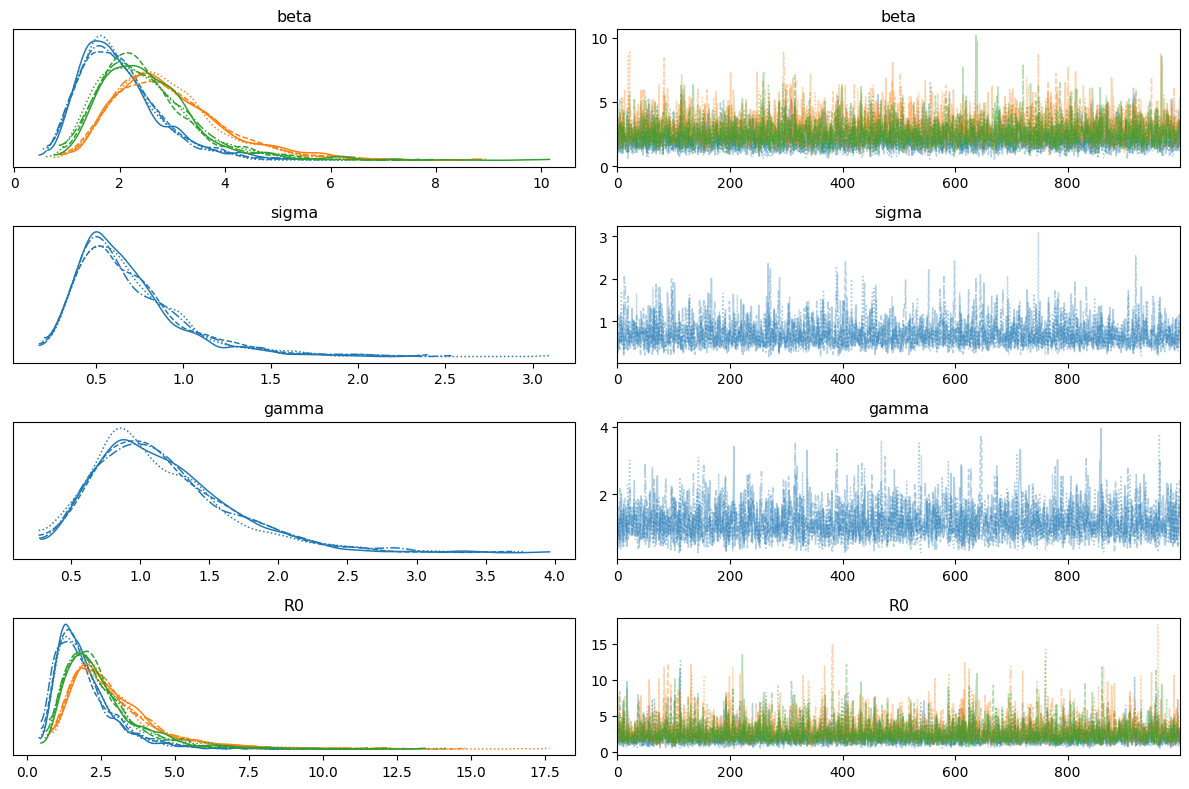

In [306]:

az.plot_trace(fit_multi_model, var_names=["beta", "sigma", "gamma", "R0"])
plt.tight_layout()
plt.show()

In [307]:
# Assuming `fit` is your CmdStanMCMC object from fitting the model
posterior_samples = fit_multi_model.draws_pd()  # returns a pandas DataFrame
parameters = ["beta[1]","beta[2]", "beta[3]", 
              "sigma", "recovery_time",
                "gamma", "incubation_period", 
                "R0[1]","R0[2]", "R0[3]",
                  "phi"]

beta = np.array([0.3, 0.4, 0.35])  # Transmission rate (R0 = beta/gamma)
sigma = 1/8.5 *7        # 1/latent period (Ebola: ~10 days) Average value
gamma = 1/6*7         # 1/infectious period (Ebola: ~7 days)
phi = 10            # Negative binomial dispersion parameter
reporting_rate = 1
r = beta/gamma
rec = 1.0/gamma
incu = 1.0 / sigma

t = {
    'beta[1]': beta[0],
    'beta[2]': beta[1],
    'beta[3]': beta[2],
    'sigma': sigma,   
    'gamma': gamma,
    'phi': 10 ,
    'reporting_rate':reporting_rate,
    'R0[1]': r[0], 'R0[2]': r[1], 'R0[3]': r[2], 
    'recovery_time':rec,
    'incubation_period': incu}

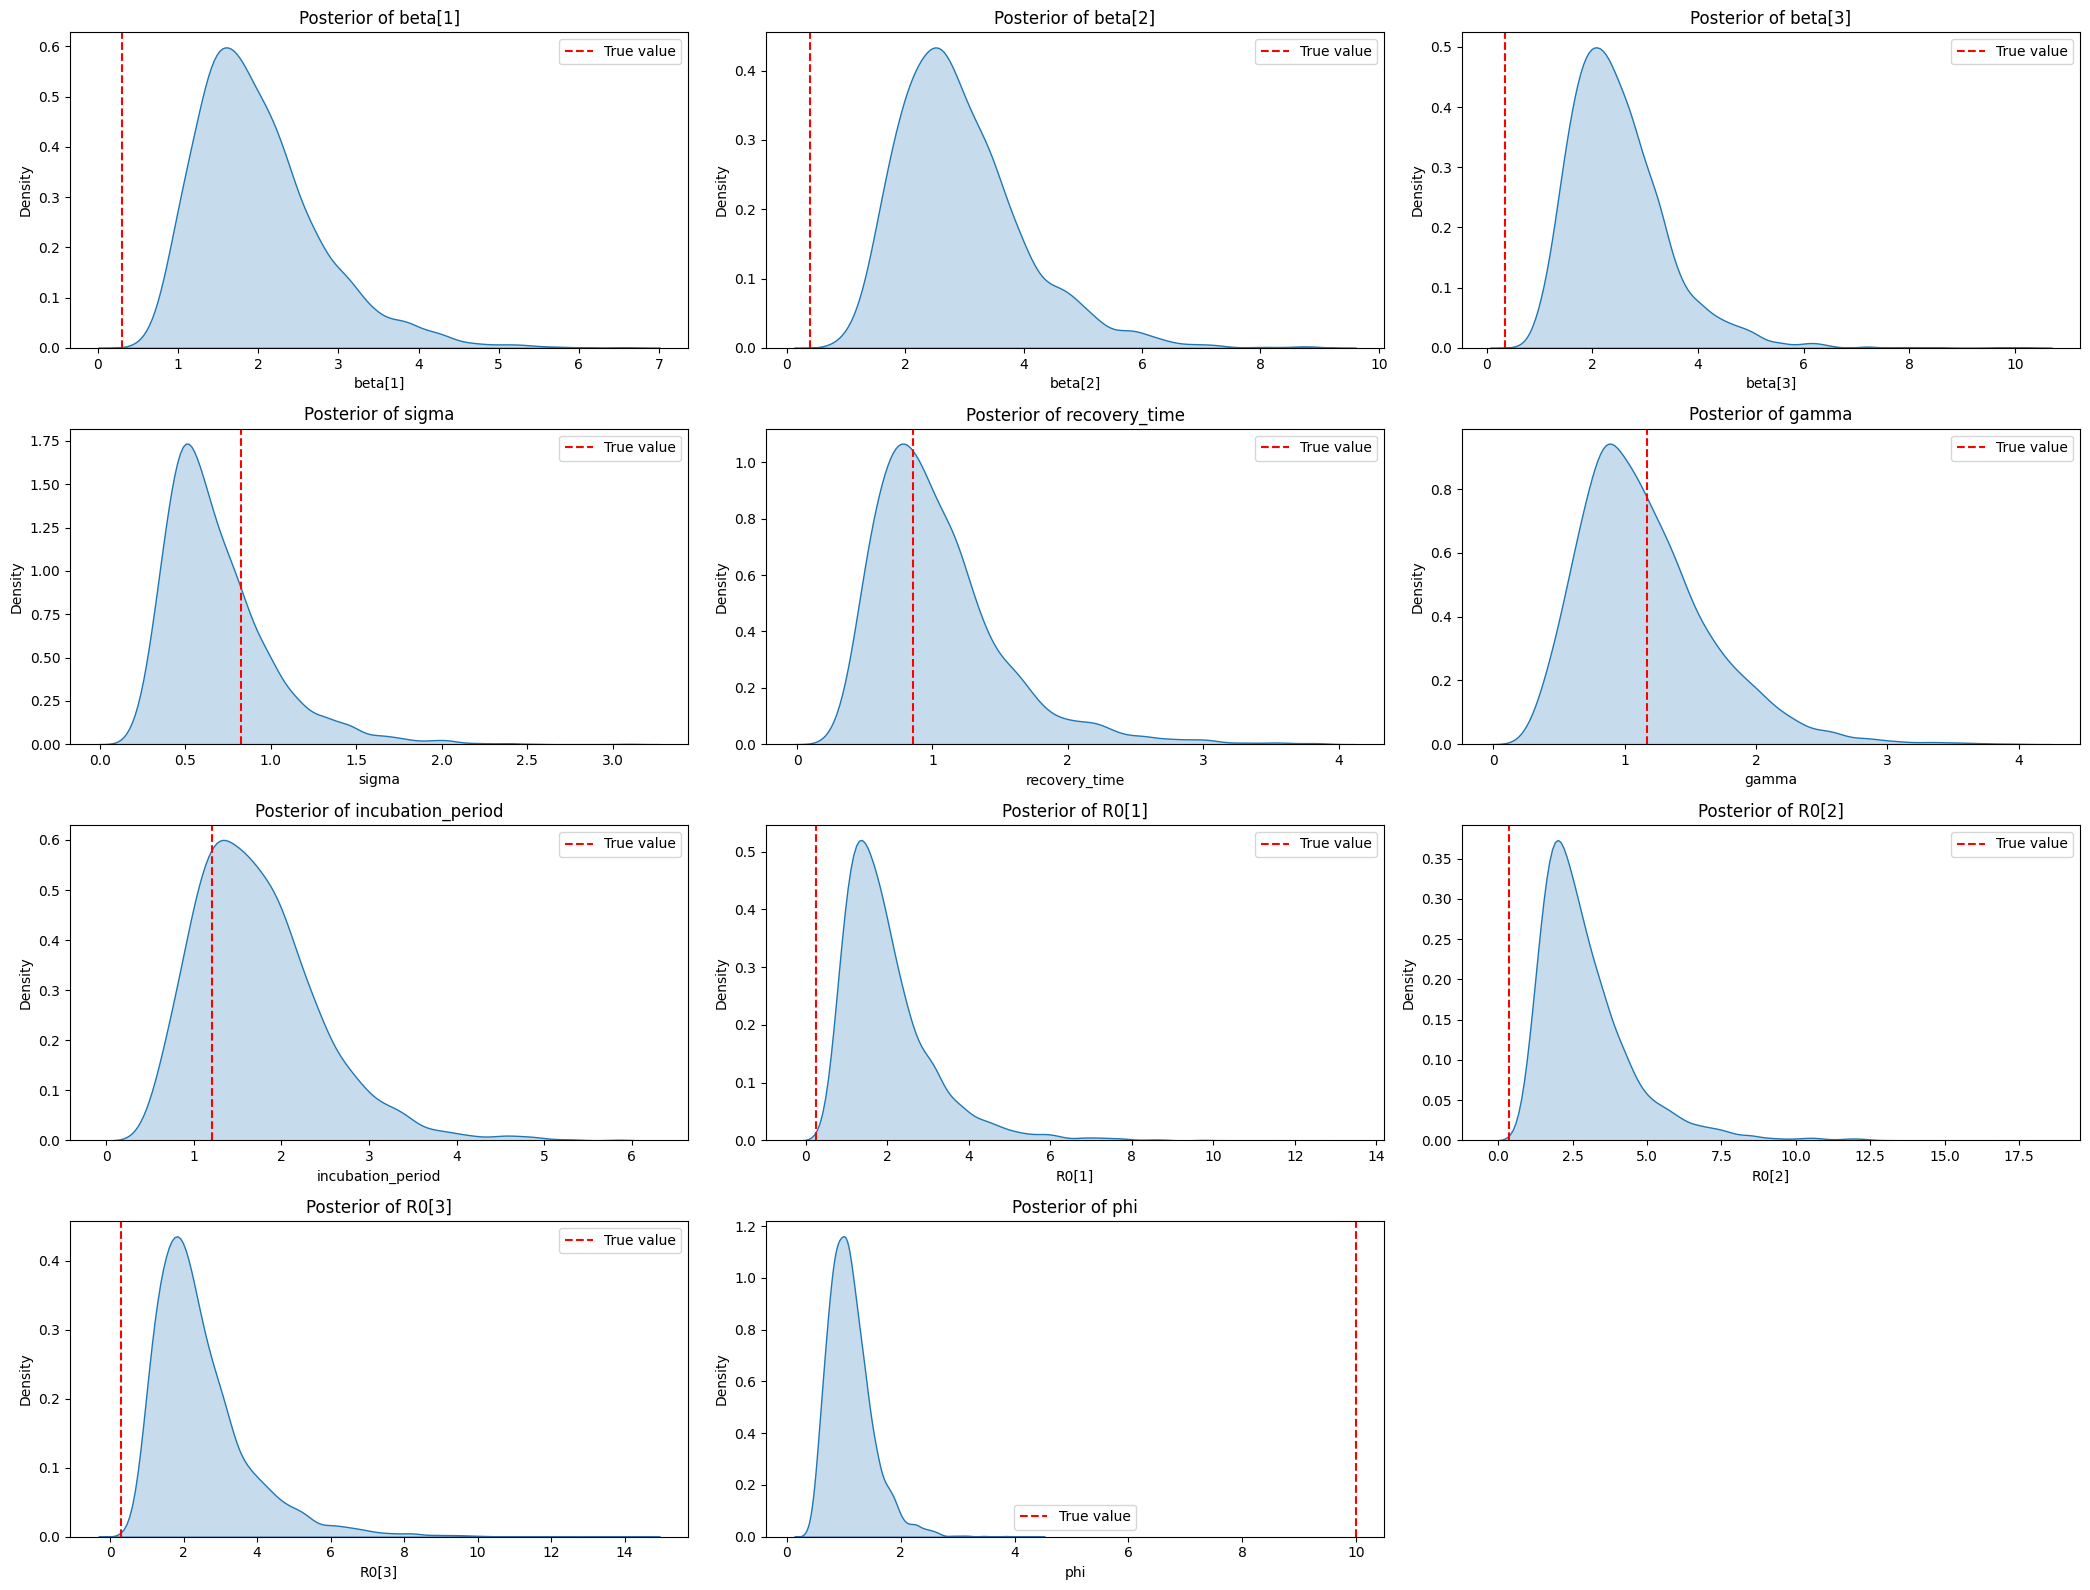

In [308]:
plot_posterior_kde_grid(fit_multi_model, parameters=parameters, 
                        n_cols=3, true_values=t)